In [1]:

#from google.colab import drive
#drive.mount('/content/drive')

# Importing Libraries

In [2]:
#Keras Libraries
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.optimizers import schedules
from keras.models import load_model


#Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import metrics


import numpy as np
import pandas as pd #For converting csv to DataFrame

#For Plotting Purpose
import matplotlib.pyplot as plt
import seaborn as sn

#For Transforming data and evaluation of Models
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from imblearn.over_sampling import RandomOverSampler

#Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier

#Hyperparameter tuning of Models
from sklearn.model_selection import GridSearchCV

#For calculating time required for Training and Testing of Models
import time

#Hide Warnings
import warnings
warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None  # default='warn'

# Loading the Data

In [3]:
#Reading the Training and Testing Data 
#Note: If you run this on your system, make sure to the absolute path/ relative path of the train and test data below. 
exoTrain = pd.read_csv('/kaggle/input/kepler-labelled-time-series-data/exoTrain.csv')
exoTest = pd.read_csv('/kaggle/input/kepler-labelled-time-series-data/exoTest.csv')

exoTrain.head(5)

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [4]:
#Printing the count of Labels
#1 ---> Not Exoplanet
#2 ---> Exoplanet

exoTrain['LABEL'].value_counts()
print(exoTest['LABEL'].value_counts())

LABEL
1    565
2      5
Name: count, dtype: int64


# EDA (EXPLORATORY DATA ANALYSIS)

In [5]:
def flux_graph(dataset, row, dataframe, planet):

  fig = plt.figure(figsize=(10,5))
  ax = fig.add_subplot()
  ax.set_title(planet, fontsize=22)
  ax.set_xlabel('time', fontsize=17)
  ax.set_ylabel('flux_' + str(row), fontsize=17)
  ax.grid(False)
  if dataframe:
    flux_time = list(dataset.columns)
    flux_values = dataset[flux_time].iloc[row]
  else:
    flux_values = dataset[row]

  ax.plot(range(1, len(flux_values) + 1),flux_values)
  ax.tick_params(colors='black', labelsize=14)
  plt.show()


In [6]:
def display_flux(dataframe, dataset):
    with_planet = exoTrain[exoTrain['LABEL'] == 2].head(1).index
    wo_planet = exoTrain[exoTrain['LABEL'] == 1].head(1).index

    for row in with_planet:
        flux_graph(dataset, row, dataframe, planet = 'At least One Exoplanet')
    for row in wo_planet:
        flux_graph(dataset, row, dataframe, planet = 'No Exoplanet')

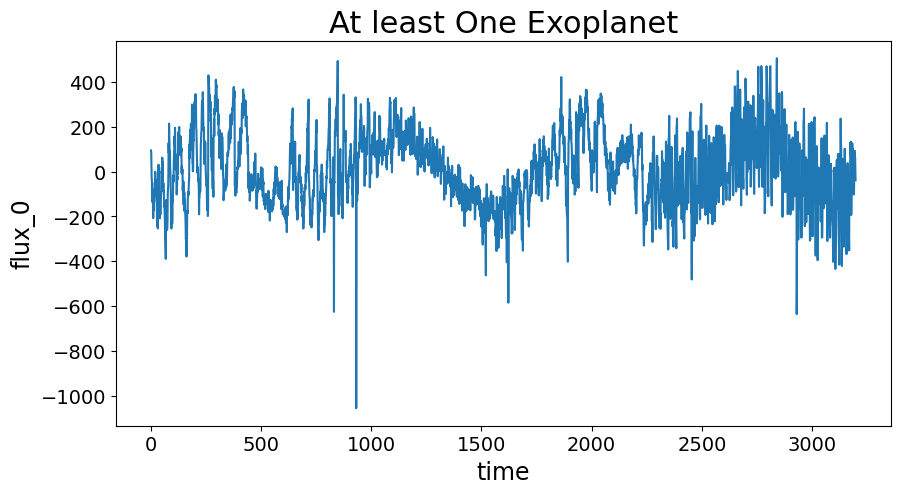

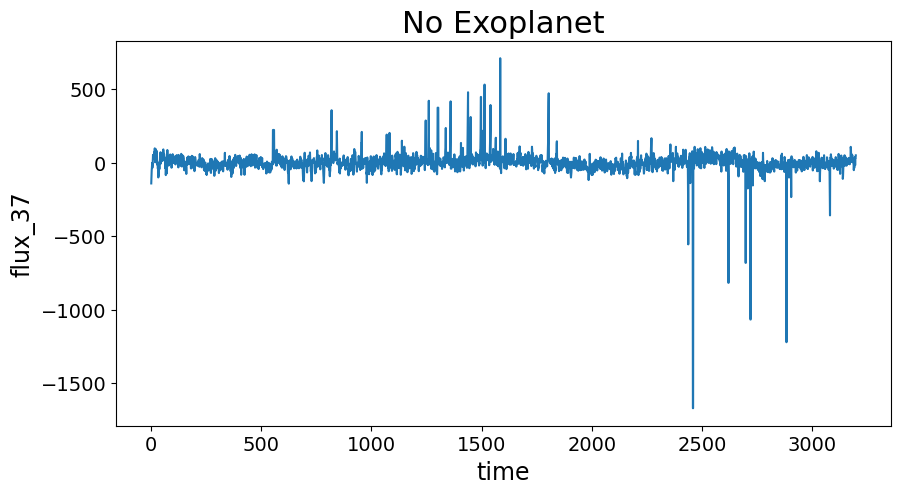

In [7]:
display_flux(True, dataset = exoTrain.loc[:, exoTrain.columns != 'LABEL'])

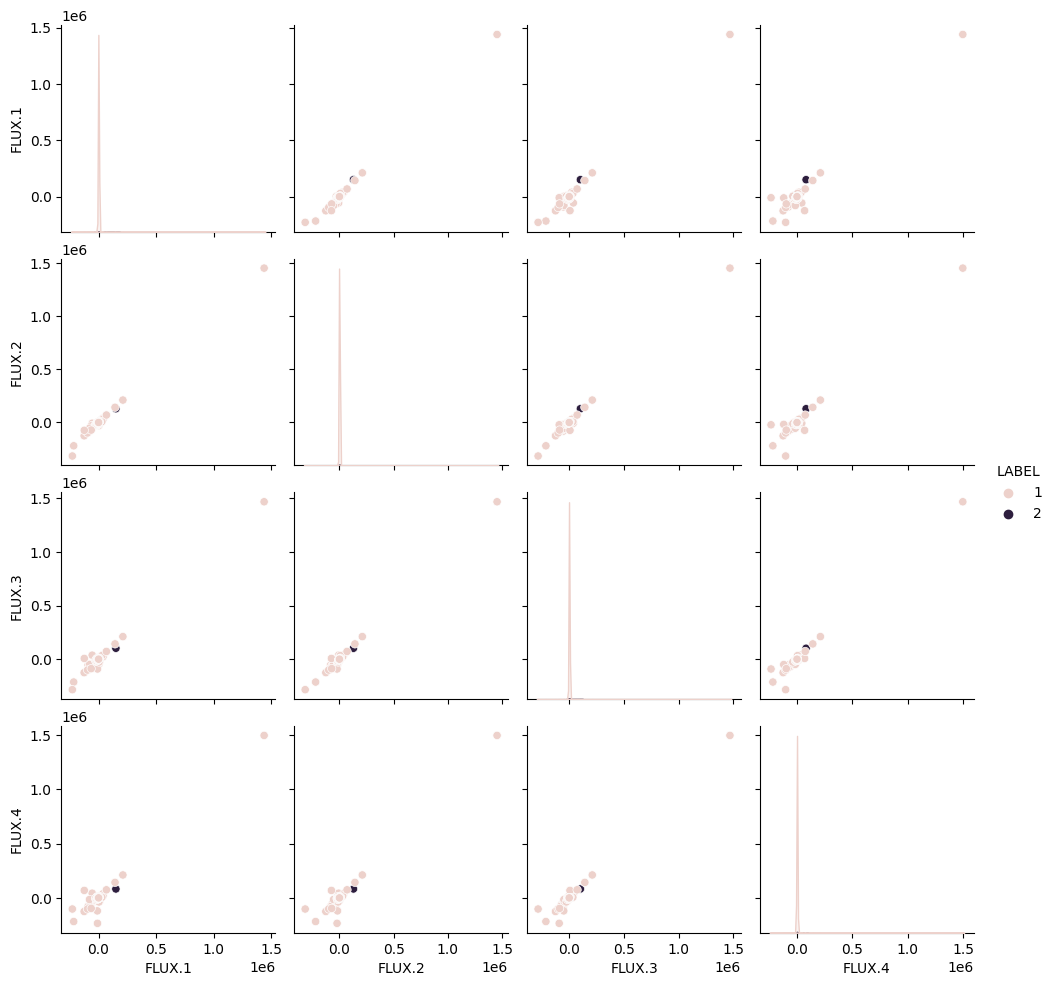

In [8]:
#PairPlot for first 10 columns
subset_data = exoTrain.iloc[:, :5]
sn.pairplot(subset_data, hue='LABEL')

<Axes: xlabel='FLUX.1', ylabel='Density'>

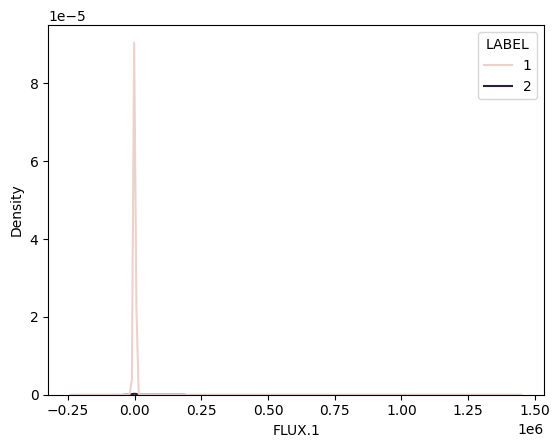

In [9]:
#KDEplot for FLUX.1
sn.kdeplot(data = subset_data, hue = 'LABEL',x='FLUX.1')

# Data Preprocessing

In [10]:
def handle_outliers(dataset, num_iterations):
    dataset_outlier = dataset

    for n in range(num_iterations):
        for index, row in dataset_outlier.iterrows():
            row_values = row.values
            row_max, row_min = row_values.max(), row_values.min()
            row_maxidx, row_minidx = row_values.argmax(), row_values.argmin()
            row_mean = row_values.mean()

            dataset_outlier.iloc[index][row_maxidx] = row_mean

            dataset_outlier.iloc[index][row_minidx] = row_mean

    return dataset_outlier

In [11]:
#Changing the labels from (1 ---> 1) and (2 ---> 0)
def change_labels(y_train, y_test):
    label_changer = lambda x: 1 if x == 2 else 0
    y_train_temp = y_train.apply(label_changer)
    y_test_temp = y_test.apply(label_changer)

    return y_train_temp, y_test_temp

In [12]:
# Handling the Imbalance of datasets by oversampling
from imblearn.over_sampling import RandomOverSampler
def RVS(x_train, y_train):
    rv = RandomOverSampler(random_state = 42)
    x_train_res, y_train_res = rv.fit_resample(x_train, y_train)
    return x_train_res, y_train_res

In [13]:
# Preprocessing training and testing datasets
def pre_processing():
    x_train, y_train = exoTrain.loc[:, exoTrain.columns != 'LABEL'], exoTrain.loc[:, 'LABEL']
    x_test, y_test = exoTest.loc[:, exoTest.columns != 'LABEL'], exoTest.loc[:, 'LABEL']


    x_train = handle_outliers(x_train, 5) #Removing the outliers
    x_train, y_train = RVS(x_train, y_train) #Upsampling the data using RandomOverSampler
    y_train, y_test = change_labels(y_train, y_test) #Changing the labels from (1 --> 1) and (2 --> 0)
 
    return x_train, y_train, x_test, y_test

In [14]:
# Printing the Confusion matrix
def plot_confusion_matrix(y_test, y_pred):

    matrix = confusion_matrix(y_test, y_pred,normalize='true')
    df = pd.DataFrame(matrix, columns=[0, 1], index = [0, 1])
    df.index.name = 'Real Values'
    df.columns.name = 'Predicted Values'
    plt.figure(figsize = (10,10)) 
    sn.heatmap(df, cmap="BuGn", annot=True)
    plt.show()
    
    return matrix

In [15]:
# Print prediction metrics
def display_predictions(y_test, y_pred, y_class_pred, matrix):

  #TP ---> TRUE POSITIVE
  #TN ---> TRUE NEGATIVE
  #FP ---> FALSE POSITIVE
  #FN ---> FALSE NEGATIVE
  TP = matrix[0][0]
  TN = matrix[1][1]
  FP = matrix[0][1] 
  FN = matrix[1][0]



  rec = TP/(TP+FN) #Recall
  accuracy = (TP+TN)/(TP+FP+TN+FN) #Accuracy
  precision = TP/(TP+FP) #Precision
  f1 = (2*precision*rec)/(precision+rec) #F1 Score
  auc = roc_auc_score(y_test, y_pred) #ROC curve (Area under curve)

  print('\t\t Prediction Metrics\n')
  print("Accuracy:\t", "{:0.4f}".format(accuracy))
  print("Precision:\t", "{:0.4f}".format(precision))
  print("Recall:\t\t", "{:0.4f}".format(rec))
  print("ROC AUC:\t", "{:0.4f}".format(auc))

# Modelling

In [16]:
#Parameters for Random Forest 
def find_best_model(model):
  # Splitting Dataset
  x_train, y_train, x_test, y_test = pre_processing()
  x_train, y_train = shuffle(x_train, y_train) # shuffle the data


  if(model == 'rf'):
    print('Finding the best Random Forest Model')
    param_grid = { 
        'n_estimators': [200,500],
        'max_features': ['sqrt','log2'],
        'max_depth' : [4,6,8],
        'criterion' :['gini']
    }
    md = RandomForestClassifier(random_state=42)
    


  elif (model == 'lr'):
    param_grid = { 
        'penalty': ['l1','l2'],
        'C':[0.0001,0.001,0.01,0.1,1,10,100,1000],
    }
    md = LogisticRegression(random_state=42)


  elif(model == 'knn'):
    param_grid = { 
      'weights' : ['uniform','distance'],
      'n_neighbors':[3,4,5],
      'p':[1,2]
    }
    md = KNeighborsClassifier()

  elif(model == 'lightgbm'):
    param_grid = {
      'learning_rate': [1,0.1, 0.01],
      'n_estimators': [100, 150],
      'max_depth': [6, 8],
    }
    md = lgb.LGBMClassifier(random_state=42)


  CV_md = GridSearchCV(estimator=md, param_grid=param_grid, cv= 5, scoring = 'recall')


  start = time.time()
  CV_md.fit(x_train, y_train)
  end = time.time()


  print('Total Time Required : \n', end-start)

  best = CV_md.best_estimator_ #Best Estimator
  print('Best Estimator is : \n')
  print(best)
  clf = best
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)

  print('The Confusion Matrix is: \n')
  print(plot_confusion_matrix(y_test, y_pred))

  print('Classification Report is: \n')
  print(classification_report(y_test, y_pred))


## Random Forest

Finding the best Random Forest Model
Total Time Required : 
 1517.3752844333649
Best Estimator is : 

RandomForestClassifier(max_depth=4, n_estimators=200, random_state=42)
The Confusion Matrix is: 



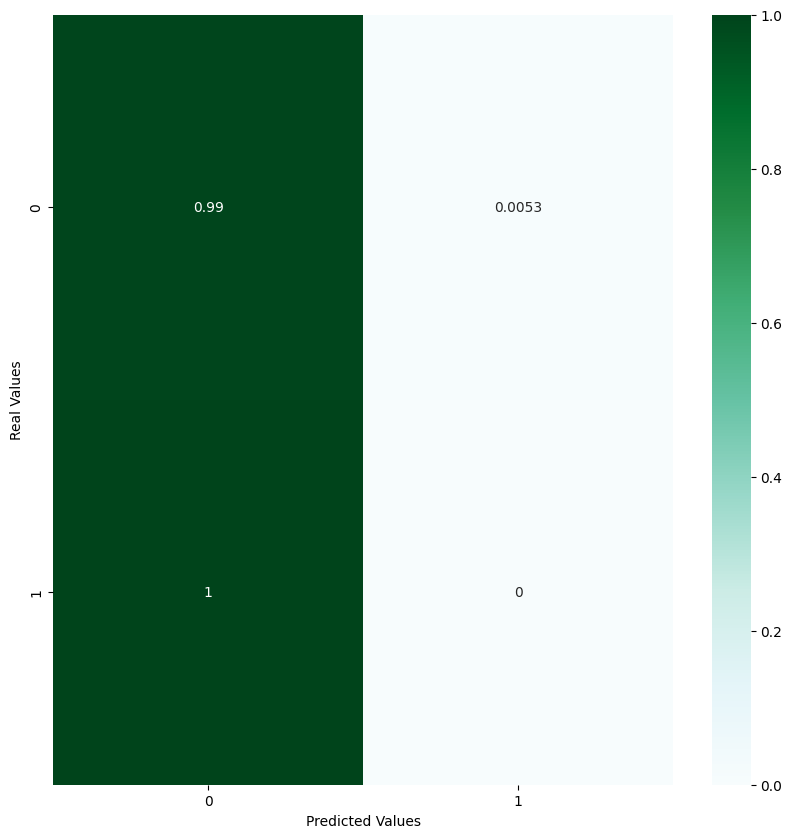

[[0.99469027 0.00530973]
 [1.         0.        ]]
Classification Report is: 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.98       570



In [17]:
find_best_model('rf')

## Logistic Regression

Total Time Required : 
 278.3732678890228
Best Estimator is : 

LogisticRegression(C=0.0001, random_state=42)
The Confusion Matrix is: 



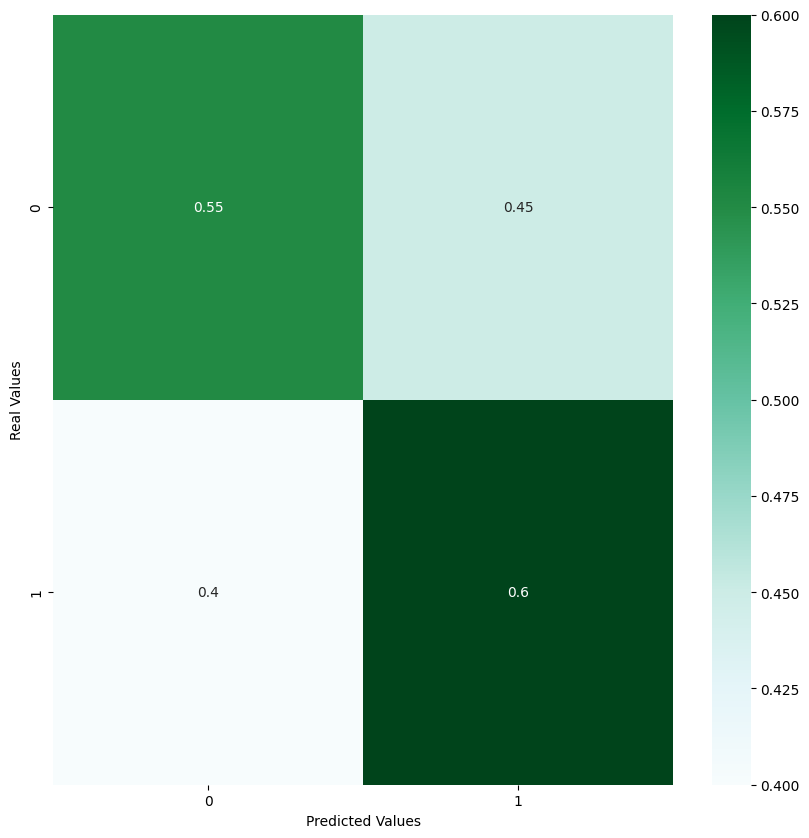

[[0.55044248 0.44955752]
 [0.4        0.6       ]]
Classification Report is: 

              precision    recall  f1-score   support

           0       0.99      0.55      0.71       565
           1       0.01      0.60      0.02         5

    accuracy                           0.55       570
   macro avg       0.50      0.58      0.37       570
weighted avg       0.98      0.55      0.70       570



In [18]:
find_best_model('lr')

## K Nearest Neighbours

Total Time Required : 
 2661.9820137023926
Best Estimator is : 

KNeighborsClassifier(n_neighbors=3, p=1)
The Confusion Matrix is: 



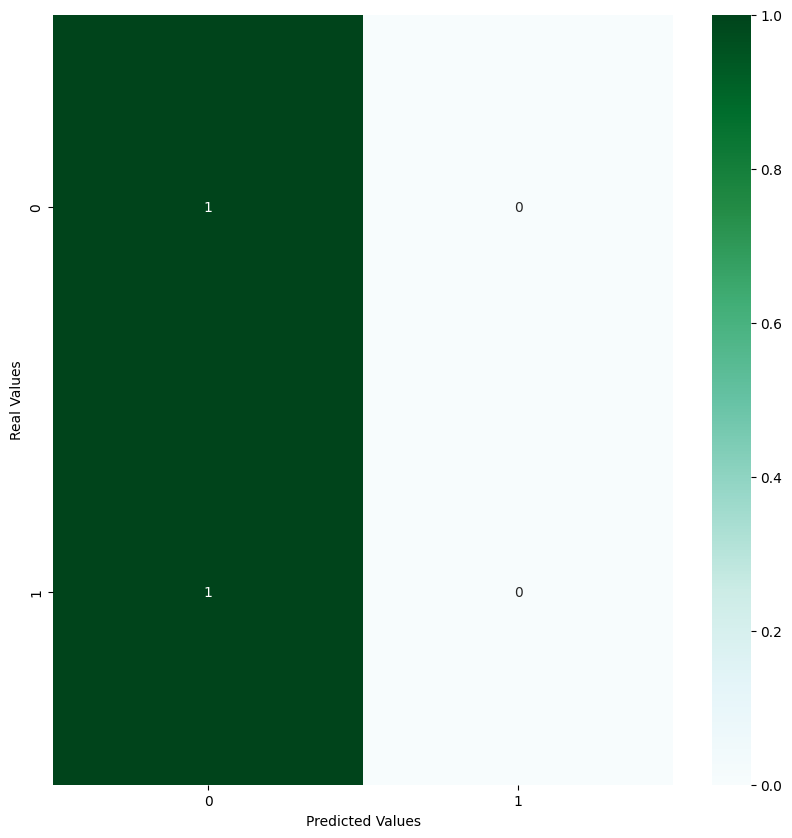

[[1. 0.]
 [1. 0.]]
Classification Report is: 

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



In [19]:
find_best_model('knn')

## LIGHT GRADIENT BOOSTING 

Total Time Required : 
 1965.4151527881622
Best Estimator is : 

LGBMClassifier(learning_rate=1, max_depth=6, random_state=42)
The Confusion Matrix is: 



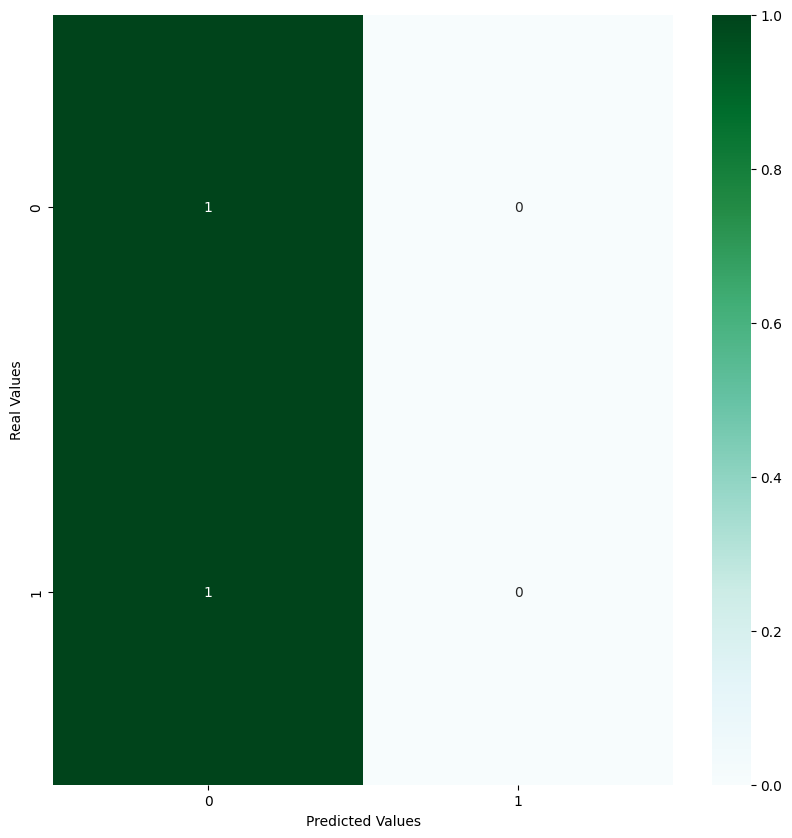

[[1. 0.]
 [1. 0.]]
Classification Report is: 

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



In [20]:
find_best_model('lightgbm')

## Proposed CNN Model

In [21]:
def cnn_model():

    # Data preparation
    x_train, y_train, x_test, y_test = pre_processing()
    x_train, y_train = shuffle(x_train, y_train) # shuffle the data to avoid stagnant 0.0000e+00 val_accuracy


    n_features = x_train.shape[1]

    # Architecture
    model = keras.Sequential()
    model.add(layers.Reshape((3197, 1), input_shape=(3197,)))
    model.add(layers.Normalization())
    model.add(layers.Conv1D(filters=11, kernel_size=2, activation='relu', input_shape=(n_features, 1), kernel_regularizer='l2'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(filters=7, kernel_size=2, activation='relu', input_shape=(n_features, 1), kernel_regularizer='l2'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2, strides=2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(50, activation="relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(30, activation="relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(12, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))

    # Representation of architecture
    print(model.summary())

    # Compile model
    lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2, decay_steps=10000, decay_rate=0.8)

    model.compile(optimizer = Adam(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=[metrics.Recall()])

    # Fit model
    early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

    history = model.fit(x_train, y_train, validation_split = 0.2, batch_size=64, callbacks=[early_stop], epochs=30, verbose=2)


    #Training Prediction
    print('Training Prediction:')
    y_class_pred = (model.predict(x_train) > 0.5).astype("int32")
    y_pred = model.predict(x_train)

    # Calculating the Confustion Matrix
    matrix = plot_confusion_matrix(y_train, y_class_pred)

    # Displaying the Output Predictions
    display_predictions(y_train, y_pred, y_class_pred, matrix)



    # Testing Predictions
    print('Testing Prediction:')
    y_class_pred = (model.predict(x_test) > 0.5).astype("int32")
    y_pred = model.predict(x_test)

    # Confustion matrix
    matrix = plot_confusion_matrix(y_test, y_class_pred)


    # Metrics
    display_predictions(y_test, y_pred, y_class_pred, matrix)
      


We do not get the best results in the first iteration, but are able to achieve it after multiple iterations.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 3197, 1)           0         
                                                                 
 normalization (Normalizatio  (None, 3197, 1)          3         
 n)                                                              
                                                                 
 conv1d (Conv1D)             (None, 3196, 11)          33        
                                                                 
 batch_normalization (BatchN  (None, 3196, 11)         44        
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 3195, 7)           161       
                                                                 
 batch_normalization_1 (Batc  (None, 3195, 7)          2

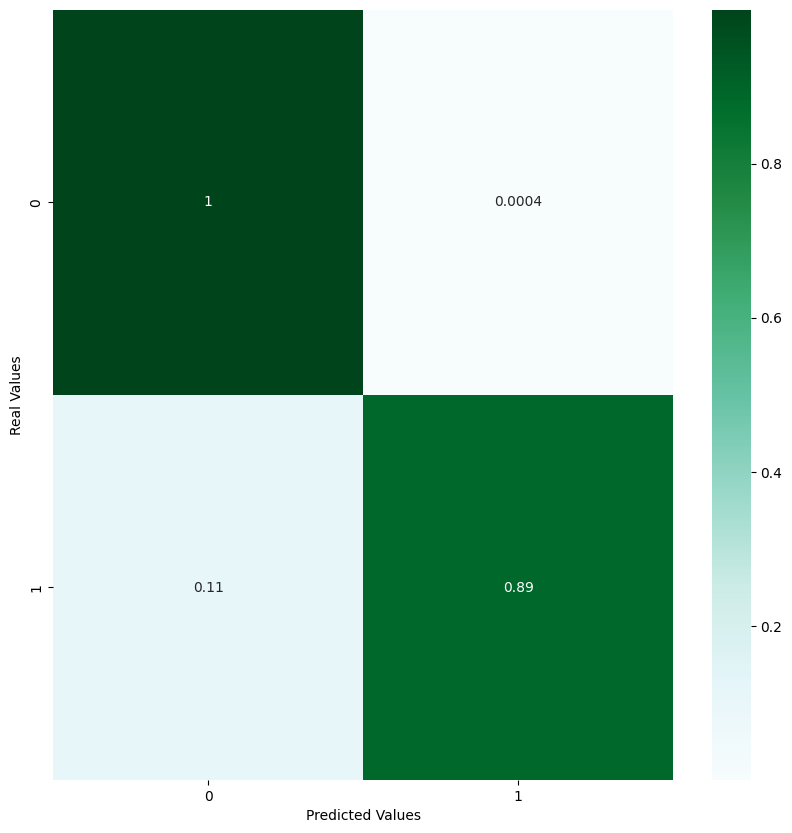

		 Prediction Metrics

Accuracy:	 0.9446
Precision:	 0.9996
Recall:		 0.9005
ROC AUC:	 0.9998
Testing Prediction:
18/18 [==============================] - 1s 37ms/step


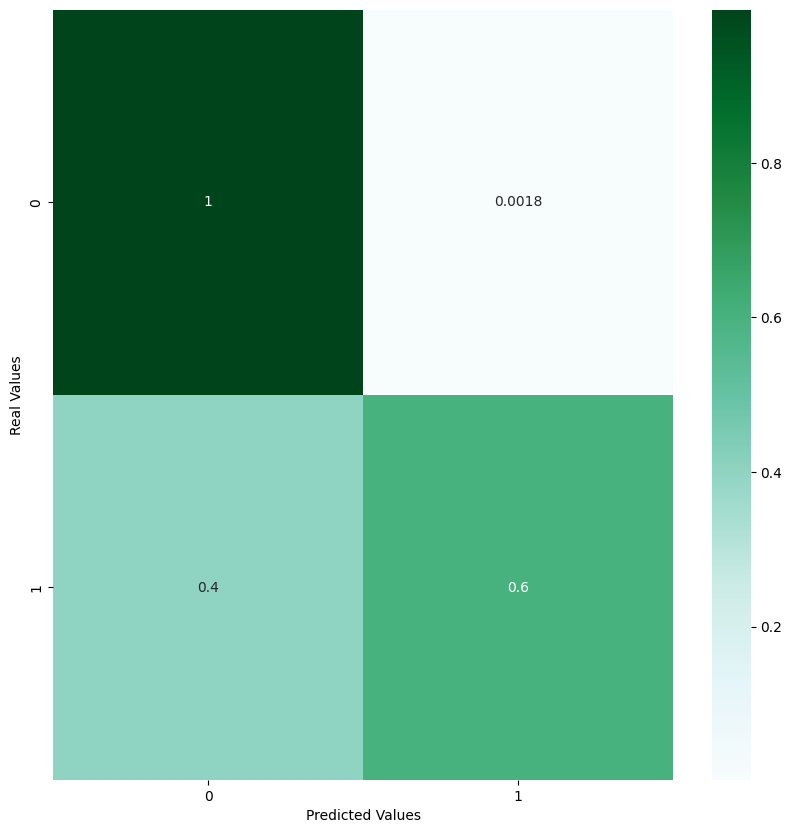

		 Prediction Metrics

Accuracy:	 0.7991
Precision:	 0.9982
Recall:		 0.7139
ROC AUC:	 0.9984


In [22]:
cnn_model()